# 0- Introducation
This Notebooks test Three different pretrained models for object detection on COCO 2017 validation dataset.
- Faster R-CNN (Two Stage Model)
- Single Shot Detector (One Stage Model)
- YOLOv3 (One Stage Model)

## **Table of content**
* [Environment Setup](#setup)
* [Imports](#imports)
* [COCO dataset](#coco)
* [Pre-trained Models](#models)
    * [Faster R-CNN](#rcnn)
    * [Single Shot Detector](#ssd)
    * [YOLOv3](#yolo)
* [Test the three models](#test)
* [Test on PASCAL dataset](#pascal)
* [Evaluation](#eval)
    * [Intersect over union](#iou)
    * [Mean average percision](#map)
* [Results](#results)






# 1- Environment Setup <a class="anchor"  id="setup"></a>

In [1]:
!pip install -q pycocotools 

# 2- Imports <a class="anchor"  id="imports"></a>

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import gluoncv
from gluoncv import model_zoo, data, utils
import mxnet as mx
from pathlib import Path
import random,os
from skimage import io
from pycocotools.coco import COCO
import matplotlib.patches as patches
import time
from tqdm import tqdm
import matplotlib.patches as mpatches

/opt/conda/lib/python3.7/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.11.0+cpu` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


# 3- Setup COCO dataset <a class="anchor"  id="coco"></a>
Common Objects In Context (COCO) dataset version 2017 mainly consist of 91 classes but the data only uses 80 classes,

pycocotools module provides us with simple API to access the images and their annotaions easly.
As our main goal to detect objects in images, every image may contains multiple objects, so for every set of images (I used validation set here) has .json file which contains all images id and for every json object contains multiple object information as bounding box, category id (class) etc.

To avoid confusion, Microsoft provided pycocotools module to access and manipulate the images and their annotaions through simple API.


In [3]:
DATA_PATH = "/kaggle/input/coco-2017-dataset/coco2017/val2017/"

# select which set you are going to use (here I used validation set)
annFile = Path('/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json')
coco = COCO(annFile)
imgIds = coco.getImgIds() # load all validation set ids

loading annotations into memory...
Done (t=1.18s)
creating index...
index created!


In [4]:
# function to get random image from validation set and it's annotaions through COCO API
def get_rand_img():
    img_id = random.choice(imgIds)
    img_metadata = coco.loadImgs([img_id]) 
    img = io.imread(DATA_PATH+img_metadata[0]['file_name'])
    annIds = coco.getAnnIds(imgIds=[img_id])
    anns = coco.loadAnns(annIds)
    return img,anns

# 4- Models <a class="anchor"  id="models"></a>

The pre-trained models we are going to use here, work with MXNet framework as the basic structure and architecture so as preprocessing step we need to:
1. convert our image (ndarray) to mxnet.ndarry to be compatiable with our models
2. transform all images to tensors as network input then applying normalizations 

In [5]:
def test_model(model,img):
    
    # preprocessing 
    mx_img = mx.nd.array(img)
    x,original_img = data.transforms.presets.rcnn.transform_test(mx_img)
    
    # time measurement
    start = time.time()
    box_ids, scores, bboxes = model(x)
    t = time.time() - start
    
    # image with model detections boxes, scores and ids
    ax = utils.viz.plot_bbox(original_img, bboxes[0], scores[0], box_ids[0], class_names=model.classes)
    return ax,t

## A) Faster R-CNN (Two stage) <a class="anchor"  id="rcnn"></a>

- **Architecture diagram**
![Faster R-CNN diagram](https://miro.medium.com/max/850/1*Fg7DVdvF449PfX5Fd6oOYA.png)

- **Breif**
Two stage based model where, first the model learn how to extract Region of proposals,
then for every Region of proposal fe perform the normal Fast R-CNN network from ROIpooling then from fully connected layer compute the two losses one for object box
(regression), and one for class type (classification).

    Each network has its own loss functions and the whole system weights consider the both
losses path, and during the test the network needs first to identify the ROI and apply Object
detection technique, so Faster R-CNN consider slower than one stage models but have
better mAP.

    The backbone network is usually a dense convolutional network like ResNet or VGG16
- **Full Explaination**

    1. [Paperspace Blog](https://blog.paperspace.com/faster-r-cnn-explained-object-detection/#:~:text=Faster%20R%2DCNN%20is%20a%20single%2Dstage%20model%20that%20is,vector%20from%20each%20region%20proposal.)
    2. [Faster R-CNN Original Paper](https://proceedings.neurips.cc/paper/2015/file/14bfa6bb14875e45bba028a21ed38046-Paper.pdf)

In [6]:
rcnn = model_zoo.get_model('faster_rcnn_resnet50_v1b_coco', pretrained=True)
# https://cv.gluon.ai/model_zoo/detection.html

123472KB [00:04, 26256.67KB/s]                            


In [7]:
# bounding box is defined by four values in pixels [x_min, y_min, width, height]
def display_ground_truth(image,boxes):
    cpy_img = image.copy()
    fig, ax = plt.subplots()
    ax.imshow(cpy_img)
    for box in boxes:
        rect = patches.Rectangle((int(box['bbox'][0]), int(box['bbox'][1])), int(box['bbox'][2]), int(box['bbox'][3]), linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.set_title("Ground Truth")
    plt.show()

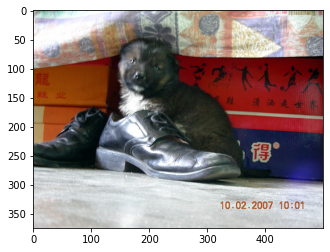

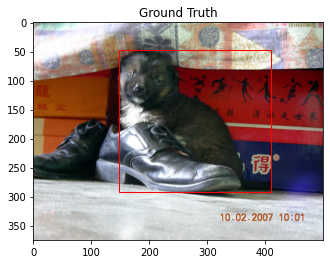

In [8]:
img,anns = get_rand_img()
plt.imshow(img)
display_ground_truth(img,anns)

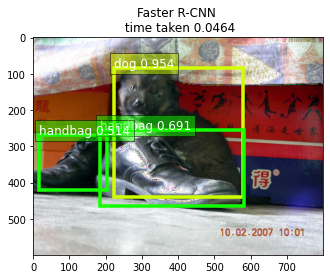

In [9]:
ax,t = test_model(rcnn,img)
ax.set_title(f"Faster R-CNN \n time taken {round(t,4)}",)
plt.show()

## B) Single Shot Detector (One stage) <a class="anchor"  id="ssd"></a>

- **Architecture diagram**
![single ](https://cdn-images-1.medium.com/max/1000/1*GmJiirxTSuSVrh-r7gtJdA.png)

- **Breif**
SSD has two components: a backbone model and SSD head.Backbone model usually is a pre-trained image classification network as a feature
extractor. This is typically a network like ResNet trained on ImageNet from which
the final fully connected classification layer has been removed. We are thus left with
a deep neural network that is able to extract semantic meaning from the input image
The SSD head is just one or more convolutional layers added to this backbone and
the outputs are interpreted as the bounding boxes and classes of objects in the
spatial location of the final layers activations

- **Full Explaination**
    1. [How SSD works](https://developers.arcgis.com/python/guide/how-ssd-works/#:~:text=SSD%20uses%20a%20matching%20phase,object's%20class%20and%20its%20location.)
    2. [Original SSD paper](https://www.cs.unc.edu/~wliu/papers/ssd.pdf)

In [10]:
ssd = model_zoo.get_model('ssd_512_resnet50_v1_coco', pretrained=True)

/opt/conda/lib/python3.7/site-packages/mxnet/gluon/block.py:1784: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


181189KB [00:06, 27258.64KB/s]                            


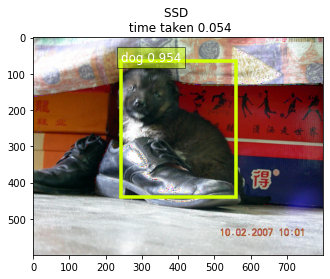

In [11]:
ax,t = test_model(ssd,img)
ax.set_title(f"SSD \n time taken {round(t,4)}",)
plt.show()

## C) YOLOv3 (One stage) <a class="anchor"  id="yolo"></a>
- **Architecture diagram**
![YOLOv3 architecture](https://viso.ai/wp-content/uploads/2021/02/YOLOv3-how-it-works.jpg)
- **Overview**

    YOLO is a Convolutional Neural Network (CNN) for performing object detection in real-time. CNNs are classifier-based systems that can process input images as structured arrays of data and recognize patterns between them (view image below). YOLO has the advantage of being much faster than other networks and still maintains accuracy.

    It allows the model to look at the whole image at test time, so its predictions are informed by the global context in the image. YOLO and other convolutional neural network algorithms “score” regions based on their similarities to predefined classes.

    High-scoring regions are noted as positive detections of whatever class they most closely identify with. For example, in a live feed of traffic, YOLO can be used to detect different kinds of vehicles depending on which regions of the video score highly in comparison to predefined classes of vehicles
    
- **Full Explaination**
    1. [YOLOv3 Guide](https://viso.ai/deep-learning/yolov3-overview/#:~:text=YOLOv3%20AI%20models-,What%20is%20YOLOv3%3F,network%20to%20detect%20an%20object.)
    2. [Original Paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf)


In [12]:
yolo = model_zoo.get_model('yolo3_darknet53_coco', pretrained=True)

100%|██████████| 224190/224190 [00:08<00:00, 27588.58KB/s]


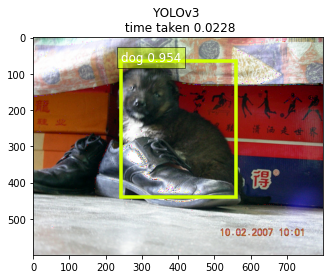

In [13]:
ax,t = test_model(ssd,img)
ax.set_title(f"YOLOv3 \n time taken {round(t,4)}",)
plt.show()

# 5- Test three models <a class="anchor"  id="test"></a>

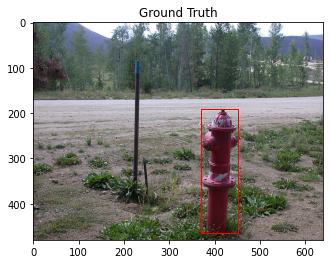

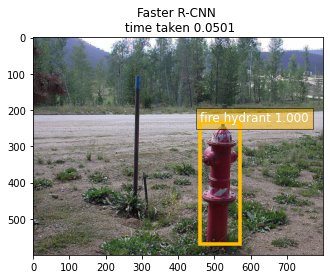

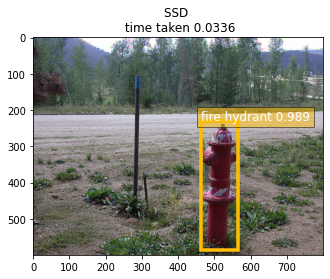

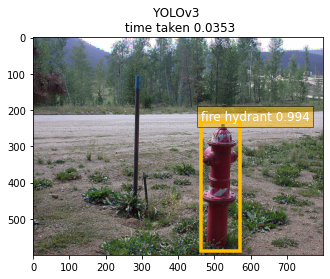

In [14]:
img,anns = get_rand_img()
display_ground_truth(img,anns)

ax1,t1 = test_model(rcnn,img)
ax1.set_title(f"Faster R-CNN \n time taken {round(t1,4)}",)
plt.show()
ax2,t2 = test_model(ssd,img)
ax2.set_title(f"SSD \n time taken {round(t2,4)}",)
plt.show()
ax3,t3 = test_model(yolo,img)
ax3.set_title(f"YOLOv3 \n time taken {round(t3,4)}",)
plt.show()

**Observation**

Regardless the time consuming, most of the time Faster R-CNN always detect more objects with good percision (correct Bounding Box) and the results is: Faster R-CNN has specific network to learn the presence and existence of an object in the image, while the SSD and YOLO have better time consuming but the results not good as Faster R-CNN but very accepeted.

That why YOLO and SSD used in real-time application where the time is huge factor (videos,cameras..) but when highly percision is needed the Region Proposed models is preferred

# 6- Test on different Dataset <a class="anchor"  id="pascal"></a>

we are going to see some results on Pascal_VOC dataset 2012
although the dataset is not croweded (few objects per image) and simpler (like not occlusion in the images)
but it is still good to try our models on different dataset

In [15]:
def generate_img():
    PATH = "/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages/"
    img_path = random.choice(os.listdir(PATH))
    rand_img = io.imread(PATH+img_path)
    return rand_img

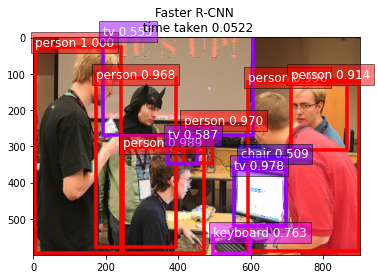

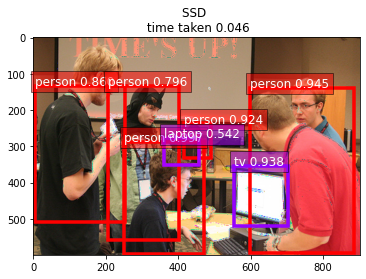

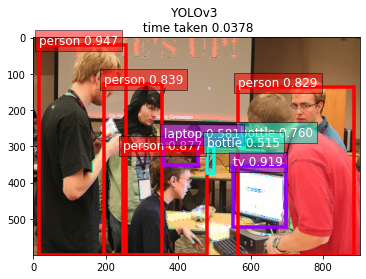

In [16]:
img = generate_img()
ax1,t1 = test_model(rcnn,img)
ax1.set_title(f"Faster R-CNN \n time taken {round(t1,4)}",)
plt.show()
ax2,t2 = test_model(ssd,img)
ax2.set_title(f"SSD \n time taken {round(t2,4)}",)
plt.show()
ax3,t3 = test_model(yolo,img)
ax3.set_title(f"YOLOv3 \n time taken {round(t3,4)}",)
plt.show()

# 7- Model Evaluation <a class="anchor"  id="eval"></a>

So how we mathematically measure the performance of our model, usually we have two metrics: 
1. Intersect over Union (IOU)
2. mean Average Percision (mAP) 

## 1. IOU <a class="anchor"  id="iou"></a>
the model need to **learn** how to identify the bounding box of an object in the image (error) so we use the IOU metric and it is simply: 
![](https://www.researchgate.net/publication/343194514/figure/fig2/AS:916944999956482@1595628132920/Intersection-Over-Union-IOU.ppm)

## 2. mAP <a class="anchor"  id="map"></a>
basically the percision measure how accurate your prediction.i.e. the percentage of your predictions are correct.

let's assume that your model predict an object in the image if the IOU > 0.5 (high overlap), and what if he missed that class or classify as incorrect label. here we use another meaure that is the average percision which consider each class seperatly and the mean consider all classes togher (their mean)



# 7- Results <a class="anchor"  id="results"></a>
we tested our pre-trained models using Fiftyone framework that compute the mAP and IOU for overall dataset on specific model.

Check the results: [Table](https://drive.google.com/file/d/1fmp1BeyvXu2vCfz2ZOt44_Ta8sKwa4zv/view?usp=sharing)

and As exptected the Faster R-CNN is outperformed over SSD and YOLOv3 in both metrics IOU and mAP